In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from tqdm.auto import trange, tqdm

import os
import math
import random
from PIL import Image
from pathlib import Path
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

import torchvision
import torchvision.utils as vutils
import torchvision.transforms as transform
from torchvision.io import read_image

import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import HTML

import sys
sys.path.append('../')
sys.path.append('../external/sg3')

from sb.nn.cifar import CifarCls
from sb.nn.mnist import MnistCLS
from sb.nn.reward import ClsReward

manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
# torch.use_deterministic_algorithms(True)

### Datasets

In [4]:
class CelebACustomCSV(Dataset):
    def __init__(self, image_dir, attr_csv, split_csv=None, split="train", transform=None):
        self.image_dir = image_dir
        self.attr_df = pd.read_csv(attr_csv)
        
        # Optional: filter by split
        if split_csv is not None:
            split_df = pd.read_csv(split_csv)
            split_df = split_df[split_df['split'] == split]
            self.attr_df = self.attr_df[self.attr_df['image_id'].isin(split_df['image_id'])]

        self.transform = transform
        self.image_ids = self.attr_df['image_id'].values
        self.labels = self.attr_df.drop(columns=['image_id']).values.astype(int)

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, image_id)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label


class CustomData(Dataset):
    def __init__(self, root):
        self.root = Path(root)
        self.transform = transform.Lambda(
            lambda x: x.float() * 2 / 255.0 - 1
        )
        self.images = list(self.root.glob('*.jpg'))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = read_image(str(image_path))
        image = self.transform(image)
        return image

In [ ]:
# dataset = CustomData("../data/creative_dataset")

# transforms = transform.Compose([
#     transform.Resize(image_size),
#     transform.CenterCrop(image_size),
#     transform.ToTensor(),
#     transform.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
# ])

# dataset = CelebACustomCSV(
#     image_dir="../data/celeba/img_align_celeba/img_align_celeba",
#     attr_csv="../data/celeba/list_attr_celeba.csv",
#     # split_csv="data/celeba/celeba_splits.csv",
#     split="train",
#     transform=transforms
# )

gen_transform = transform.Compose([
    transform.ToTensor(),
    transform.Normalize((0.5, ), (0.5, )),
])

cls_transform = transform.Compose([
    transform.ToTensor(),
])

# dataset = torchvision.datasets.CIFAR10(
#     root='../data', train=True, download=True, 
#     transform=gen_transform
# )
dataset = torchvision.datasets.MNIST(
    root='../data', train=True, 
    download=False, transform=cls_transform
)

dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, 
    shuffle=True, num_workers=4
)

def make_infinite(dl):
    while True:
        for batch in dl:
            yield batch

In [6]:
def _infer_shape(dim):
    if int(math.sqrt(dim))**2 == dim:
        sqrt_dim = int(math.sqrt(dim))
        return (1, sqrt_dim, sqrt_dim)
    
    if int(math.sqrt(dim // 3))**2 == dim // 3:
        sqrt_dim = int(math.sqrt(dim // 3))
        return (3, sqrt_dim, sqrt_dim)
    
    raise ValueError(f"Cannot infer shape from dim={dim}.")

_infer_shape(32 * 32 * 3)

(3, 32, 32)

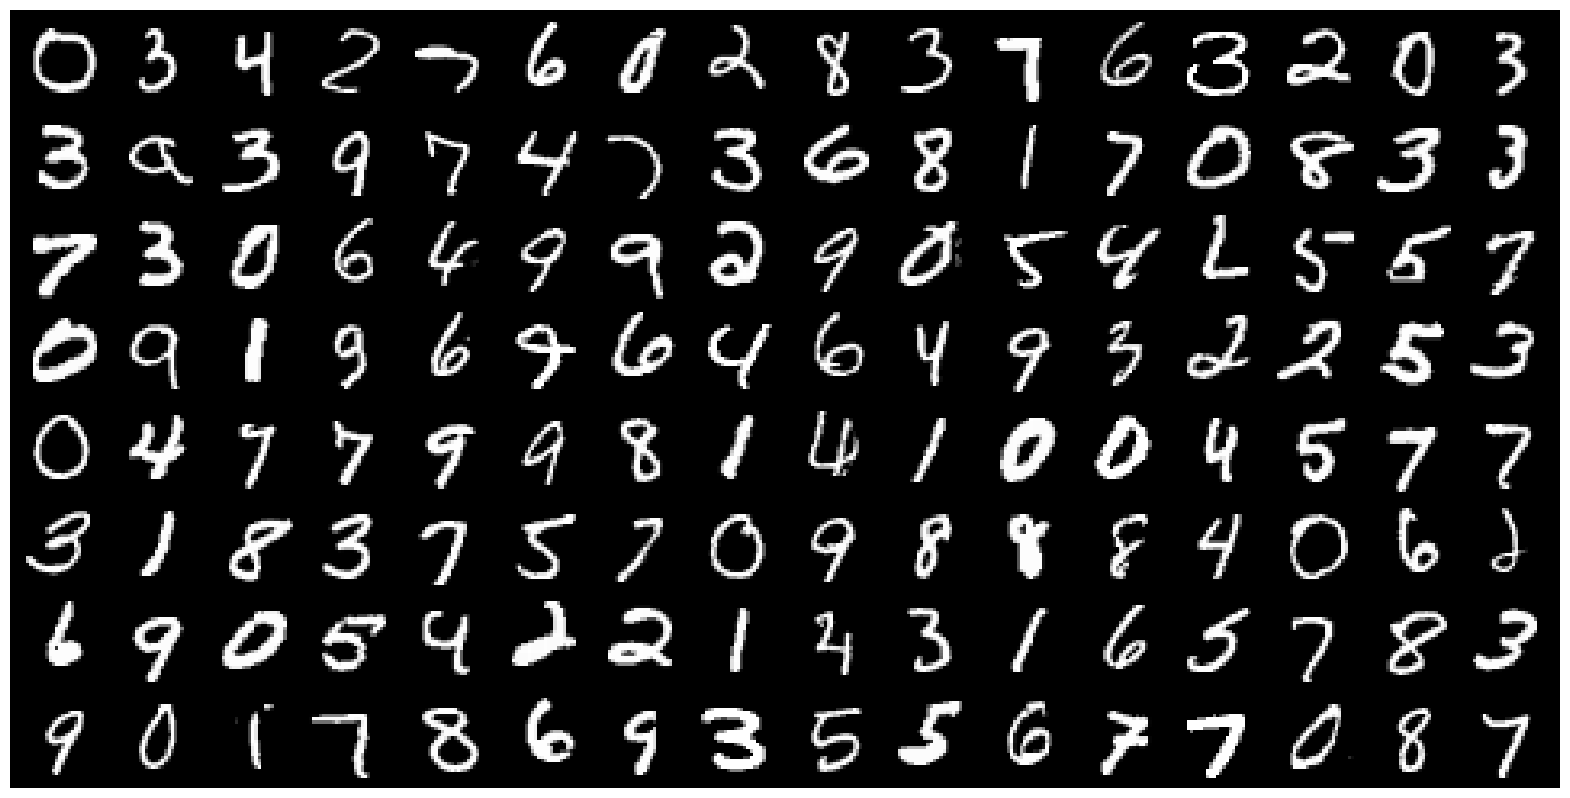

In [8]:
batch, _ = next(iter(dataloader))
# batch = (batch + 1) / 2
grid = torchvision.utils.make_grid(batch, nrow=16)
plt.figure(figsize=(20, 12))
plt.imshow(grid.permute(1, 2, 0).numpy())
plt.axis('off')
plt.show()


### Train Cls

In [24]:
num_steps = 5_001
cls_model = MnistCLS().to(device).train()
opt = optim.AdamW(cls_model.parameters(), lr=3e-3)
infinite_dataloader = make_infinite(dataloader)

loss_list = []
for step in range(num_steps):
    opt.zero_grad(set_to_none=True)
    x, y = next(infinite_dataloader)
    x, y = x.to(device), y.to(device)
    
    x = x.reshape(x.size(0), -1)
    
    logits, loss = cls_model.compute_loss(x, y, True)
    loss.backward()
    opt.step()
    
    if step % 1000 == 0:
        acc = (y == logits.softmax(dim=1).argmax(dim=1)).float().mean()
        print(f"Step: {step}, Loss: {loss.item():.3f}, Acc: {acc:.3f}")

Step: 0, Loss: 2.304, Acc: 0.102
Step: 1000, Loss: 0.045, Acc: 0.984
Step: 2000, Loss: 0.034, Acc: 0.984
Step: 3000, Loss: 0.050, Acc: 0.977
Step: 4000, Loss: 0.030, Acc: 0.984
Step: 5000, Loss: 0.002, Acc: 1.000


In [25]:
cls_model.eval().cpu()
torch.save(cls_model.state_dict(), "../rewards/mnist/mnist-cls.pt")

### Train GAN

In [106]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


class Generator(nn.Module):
    def __init__(self, z_dim, ngf):
        super().__init__()  
        self.z_dim = z_dim
        self.ngf = ngf  
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_dim, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        if z.ndim == 2:
            z = z[..., None, None]
        return self.main(z)

    
    def save_model(self, path):
        ckpt = {
            "config": {"z_dim": self.z_dim, "ngf": self.nfg},
            "state_dict": self.state_dict()
        }
        torch.save(ckpt, path)


class Discriminator(nn.Module):
    def __init__(self, ndf):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 2, 1, 0, bias=False),
            # nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [9]:
class MnistGen(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.z_dim = z_dim

        self.net = nn.Sequential(
            nn.Linear(z_dim, 200), nn.ReLU(),
            nn.Linear(200, 400), nn.ReLU(),
            nn.Linear(400, 784), nn.Tanh(),
        )
    
    def forward(self, z):
        img = self.net(z)
        return img.reshape(-1, 1, 28, 28)


class MnistDisc(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(784, 200), nn.LeakyReLU(),
            nn.Linear(200, 1), 
        )

    def forward(self, x):
        x = x.reshape(-1, 784)
        return self.net(x)

In [133]:
netG = Generator(256, 32).to(device)
# netG = MnistGen(50).to(device)
netG.apply(weights_init)
None

In [134]:
netD = Discriminator(32).to(device)
# netD = MnistDisc().to(device)
netD.apply(weights_init)
None

In [135]:
img_list = []
G_losses = []
D_losses = []

In [136]:
cls_ = CifarCls()
cls_.load_state_dict(
    torch.load('../rewards/cifar10/cifar10-cls.pt', map_location=device)
)
cls_.to(device).eval()
None

In [137]:
@torch.no_grad()
def plot_annotated_images(batch, classes_probas, n_col=8):
    classes, probas = classes_probas
    f, ax = plt.subplots(batch.size(0) // n_col, n_col, figsize=(12, 6))
    for i in range(batch.size(0)):
        row, col = divmod(i, n_col)
        ax[row, col].imshow(batch[i].permute(1, 2, 0).cpu().numpy())
        ax[row, col].axis('off')
        ax[row, col].set_title(
            f"Class `{classes[i]}`; proba={probas[i]:.2f}"
        )
    plt.tight_layout()
    plt.show()

In [138]:
optimizerG = optim.AdamW(netG.parameters(), lr=0.0006, betas=(0.5, 0.999))
optimizerD = optim.AdamW(netD.parameters(), lr=0.0004, betas=(0.5, 0.999))

Epoch: 30/30,  errD: 0.2417,  errG: 6.3570,  D(x): 0.9856,  D(G(z)): 0.3357 / 0.0029


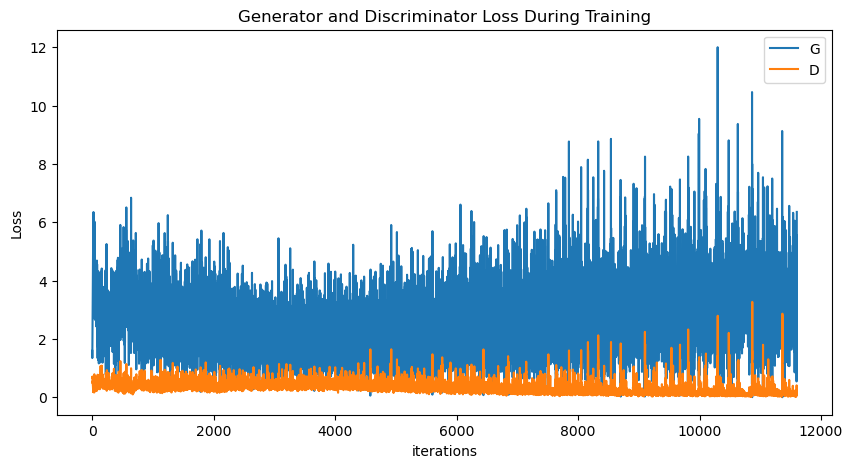

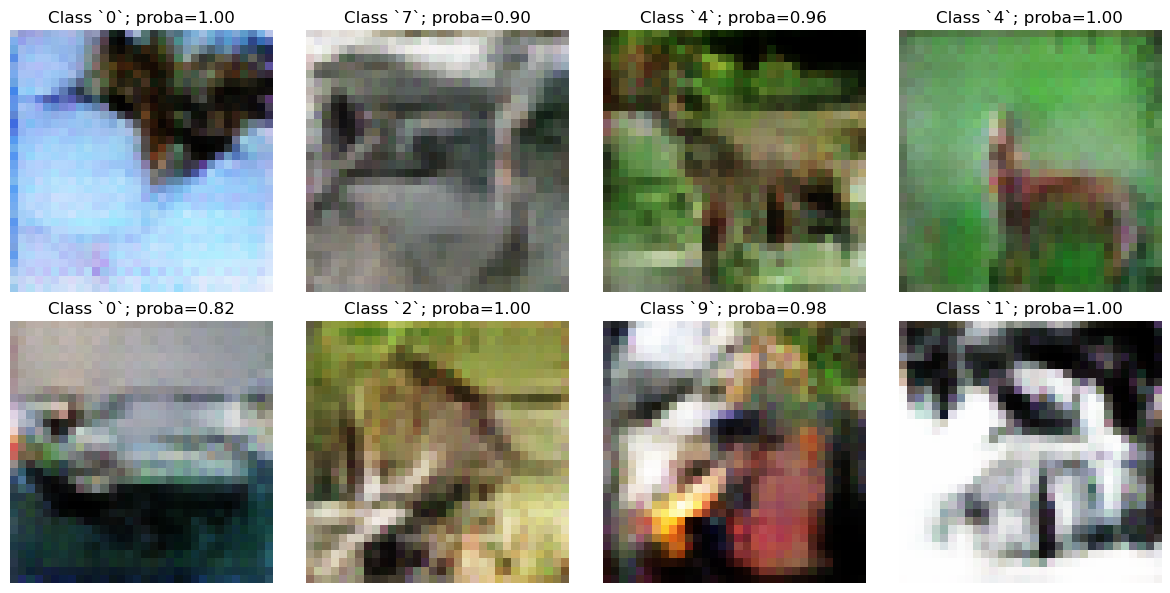

In [139]:

iters = 0
D_x = 0
num_epochs = 30

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        curr_batch_size = real_cpu.size(0)

        output = netD(real_cpu).view(-1)
        
        errD_real = nn.functional.softplus(-output).mean()
        errD_real.backward()
        D_x = nn.functional.sigmoid(output).mean().item()

        noise = torch.randn(curr_batch_size, netG.z_dim, device=device)
        fake = netG(noise)
        
        output = netD(fake.detach()).view(-1)
        errD_fake = nn.functional.softplus(output).mean()
        errD_fake.backward()
        D_G_z1 = nn.functional.sigmoid(output).mean().item()
        
        errD = (errD_real + errD_fake) / 2
        optimizerD.step()

        netG.zero_grad()
        
        noise = torch.randn(curr_batch_size, netG.z_dim, device=device)
        fake = netG(noise)
        output = netD(fake).view(-1)
        
        errG = nn.functional.softplus(-output).mean()
        errG.backward()
        optimizerG.step()
        
        D_G_z2 = nn.functional.sigmoid(output).mean().item()

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if iters % 200 == 0:
            clear_output(wait=True)
            print(
                f"Epoch: {epoch+1}/{num_epochs}, ",
                f"errD: {errD.item():.4f}, ",
                f"errG: {errG.item():.4f}, ",
                f"D(x): {D_x:.4f}, ",
                f"D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}"
            )
            plt.figure(figsize=(10,5))
            plt.title("Generator and Discriminator Loss During Training")
            plt.plot(G_losses,label="G")
            plt.plot(D_losses,label="D")
            plt.xlabel("iterations")
            plt.ylabel("Loss")
            plt.legend()
            plt.show()
            
            with torch.no_grad():
                img_for_plotting = (fake.detach()[:8] + 1) / 2
                logits = cls_(img_for_plotting).cpu()
                (probs, classes) = logits.softmax(dim=1).max(dim=1)
                plot_annotated_images(img_for_plotting, (classes, probs), n_col=4)

        iters += 1

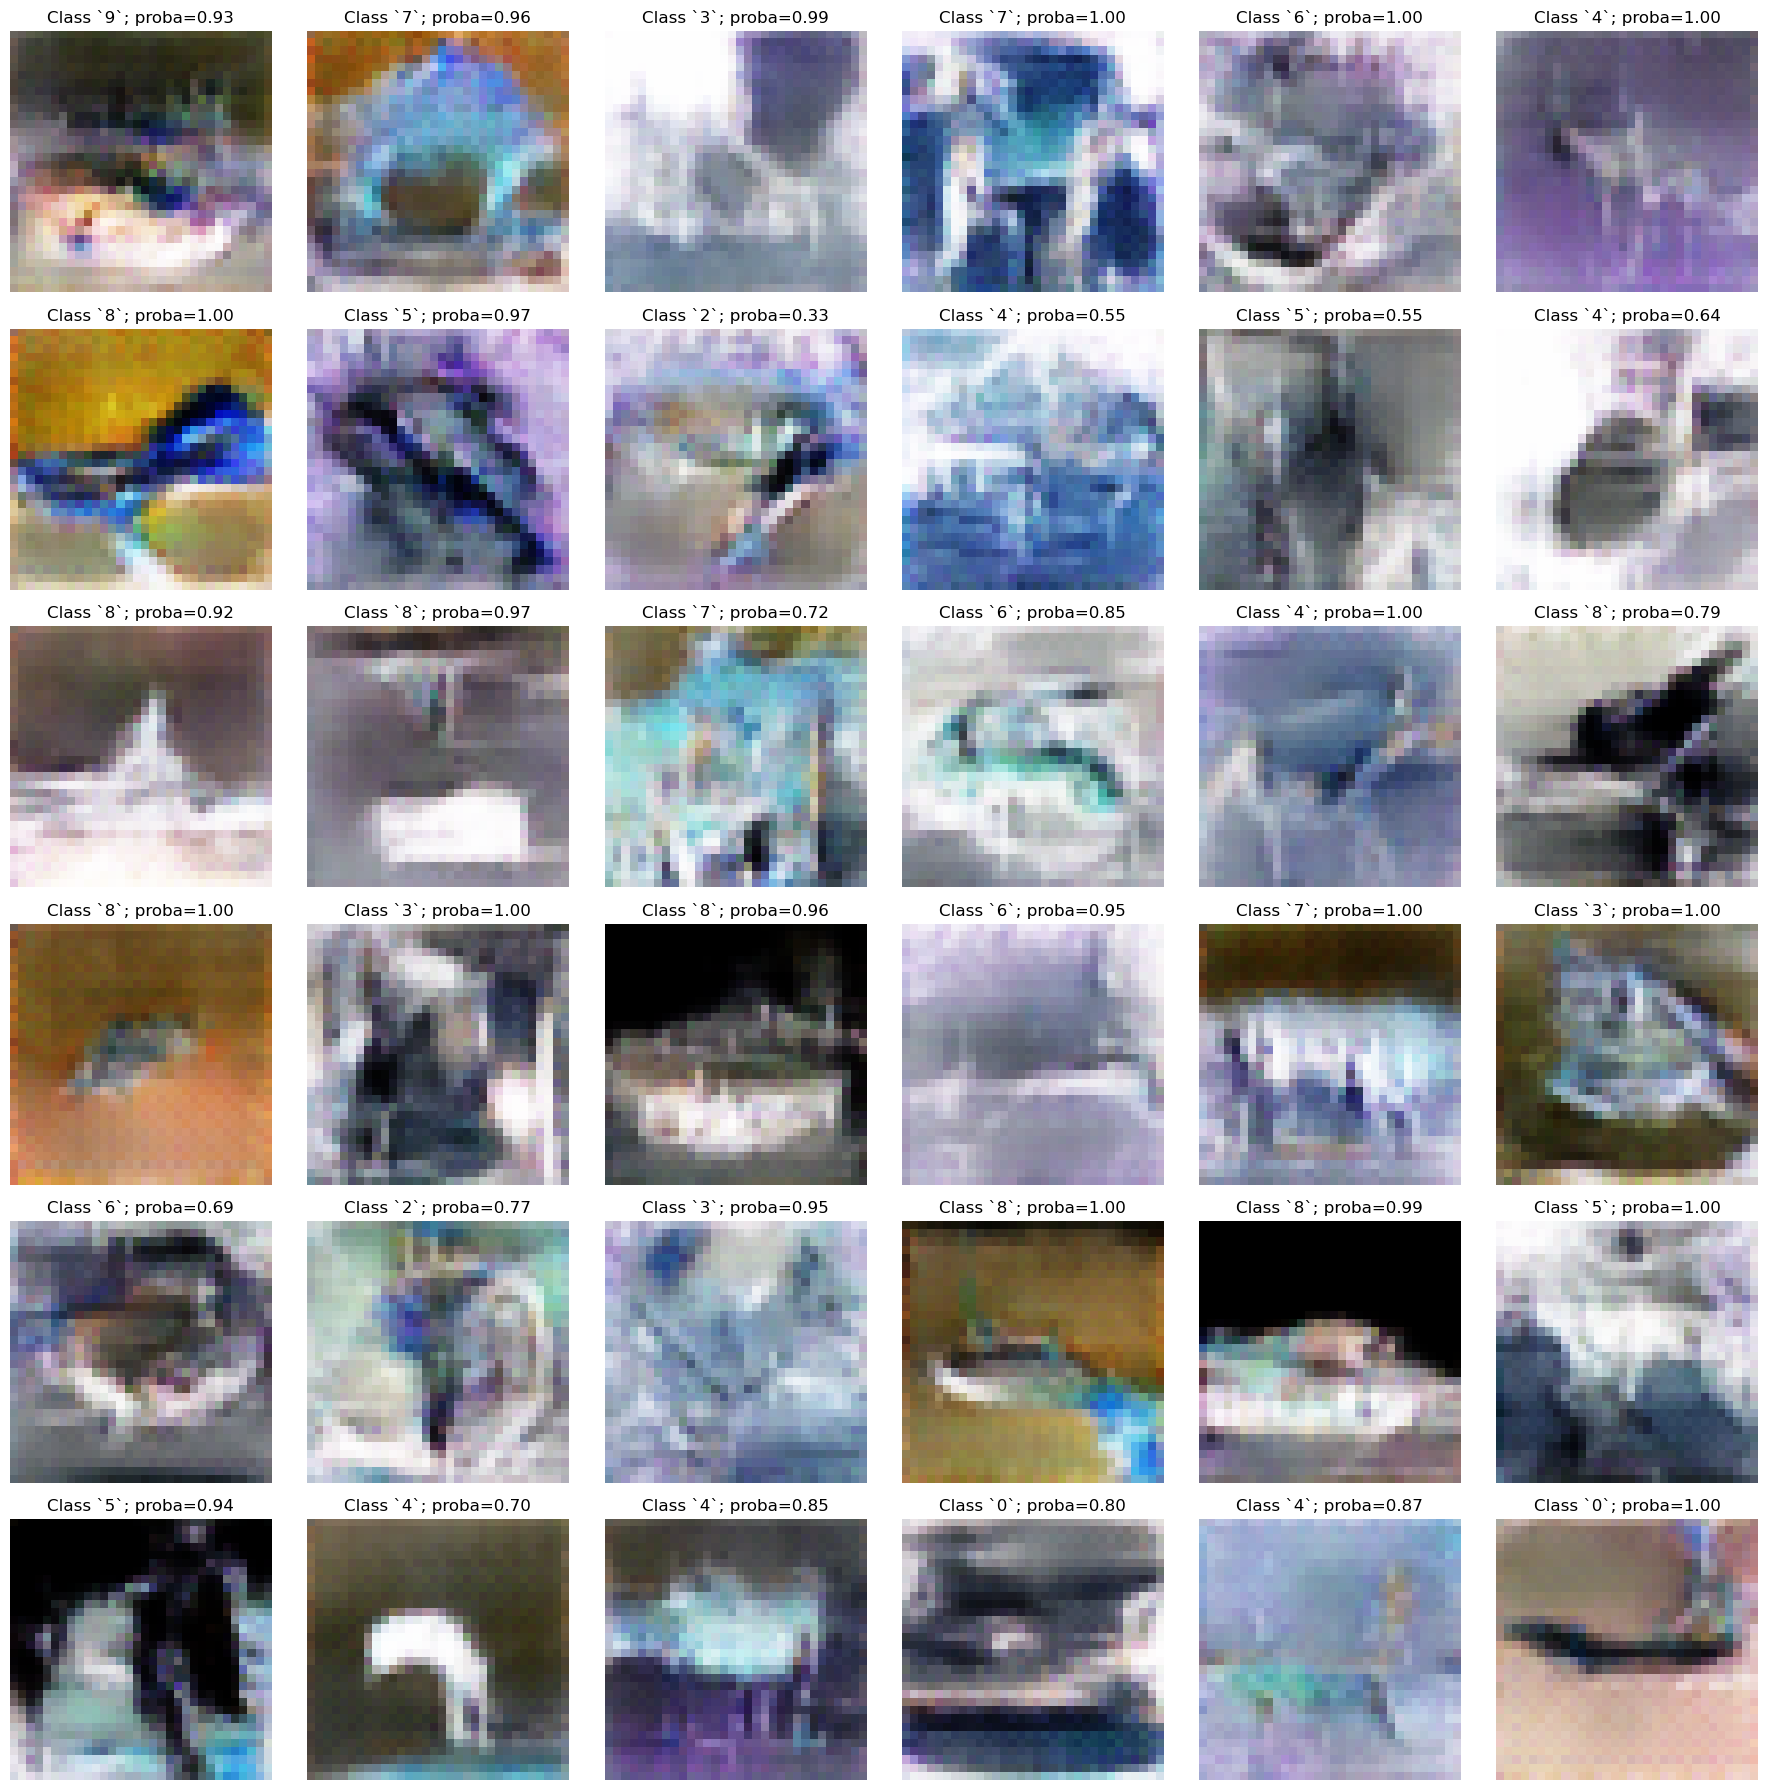

In [142]:
@torch.no_grad()
def plot_annotated_images(batch, classes_probas, n_col=6):
    classes, probas = classes_probas
    f, ax = plt.subplots(batch.size(0) // n_col, n_col, figsize=(18, 18))
    for i in range(batch.size(0)):
        row, col = divmod(i, n_col)
        ax[row, col].imshow(
            batch[i].permute(1, 2, 0).cpu().numpy(),
            cmap='Greys',
            )
        ax[row, col].axis('off')
        ax[row, col].set_title(
            f"Class `{classes[i]}`; proba={probas[i]:.2f}"
        )
    plt.tight_layout()
    plt.show()


with torch.no_grad():
    img_for_plotting = (fake.detach()[:36] + 1) / 2
    logits = cls_(img_for_plotting).cpu()
    (probs, classes) = logits.softmax(dim=1).max(dim=1)
    plot_annotated_images(1 - img_for_plotting, (classes, probs), n_col=6)

In [143]:
netG.eval().cpu()
ckpt = {
    "config": {"z_dim": netG.z_dim, "ngf": netG.ngf},
    "state_dict": netG.state_dict()
}
torch.save(ckpt, f"../rewards/cifar10/cifar10-gen-z{netG.z_dim}.pt")

### HMC

In [3]:
import sys
sys.path.append('../')

import torch
from pyro.infer.mcmc import HMC, MCMC

from sb.data.datasets import ClsRewardDist
from sb.nn.cifar import CifarCls

import matplotlib.pyplot as plt

In [ ]:


device = 'cuda:0'
reward_log_density = ClsRewardDist('cifar10-gan-z50', 'cifar10-cls', 50, [5], 'sum', device)

In [25]:
@torch.no_grad()
def plot_annotated_images(batch, classes_probas, n_col=8, figsize=(18, 9)):
    classes, probas = classes_probas
    f, ax = plt.subplots(batch.size(0) // n_col, n_col, figsize=figsize)
    for i in range(batch.size(0)):
        row, col = divmod(i, n_col)
        ax[row, col].imshow(batch[i].permute(1, 2, 0).cpu().numpy())
        ax[row, col].axis('off')
        ax[row, col].set_title(
            f"Class `{classes[i]}`; proba={probas[i]:.2f}"
        )
    plt.tight_layout()
    plt.show()

In [41]:
def potential_energy(params):
    x = params["x"]
    return - reward_log_density(x)

x0 = {"x": torch.randn(1, 50, device=device)}
hmc_kernel = HMC(
    potential_fn=potential_energy,
    step_size=0.3,
    num_steps=10,
)

In [42]:
mcmc = MCMC(hmc_kernel, num_samples=5_000, warmup_steps=200, 
            num_chains=1, initial_params=x0)
mcmc.run()

Sample: 100%|██████████| 5200/5200 [24:44,  3.50it/s, step size=3.04e-02, acc. prob=0.821]


In [43]:
samples = mcmc.get_samples(group_by_chain=True)["x"]

In [54]:
with torch.no_grad():
    rwd = reward_log_density.reward(
        samples[0, 0:-2:3 , 0]
    )
rwd.log().mean()

tensor(-0.4222, device='cuda:0')

In [38]:
cls_ = CifarCls()
cls_.load_state_dict(
    torch.load('../rewards/cifar10/cifar10-cls.pt', map_location=device)
)
cls_.to(device).eval()
None

In [46]:
with torch.no_grad():
    x = samples[0, :, 0]
    img = reward_log_density.reward.generator(x)
    img = img * 0.5 + 0.5

    (p, c) = cls_(img).softmax(dim=1).max(dim=1)

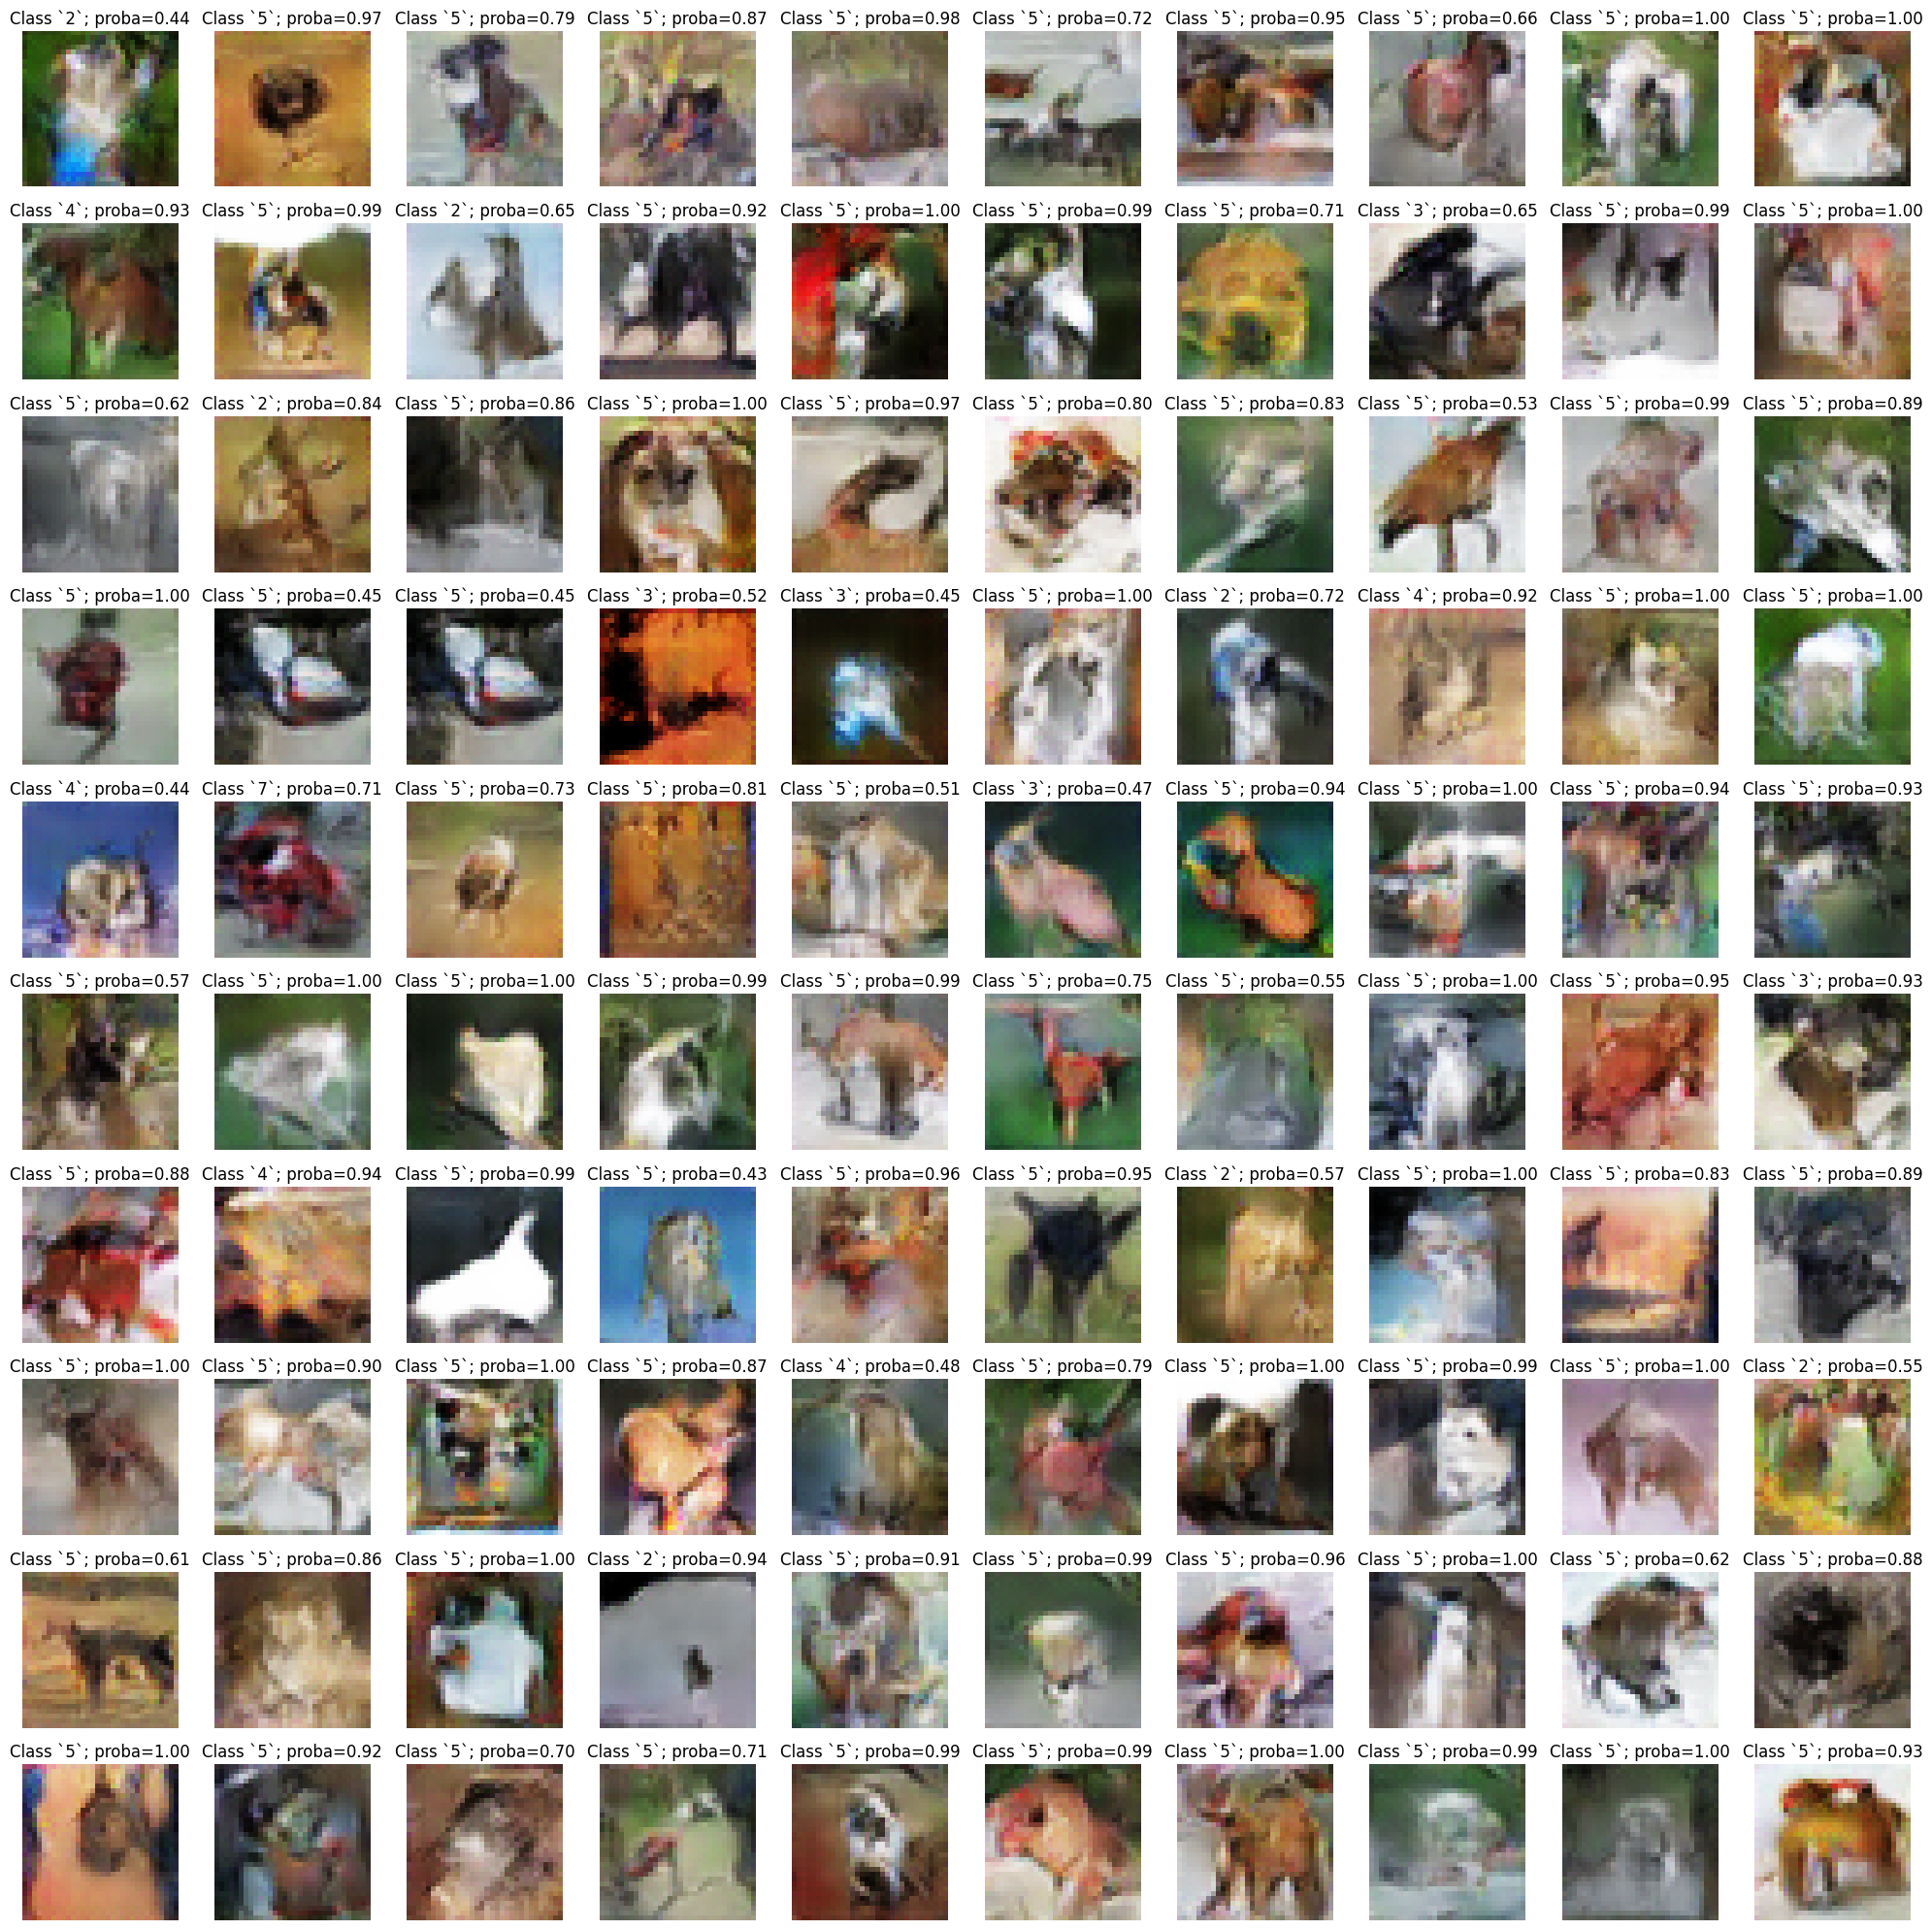

In [47]:
plot_annotated_images(img[0:300:3], (c[0:300:3], p[0:300:3]), 10, figsize=(20, 20))

In [4]:
from sb.data.datasets import MixOfGaussians, SCurve, TwoMoons
import math

In [19]:
dist = MixOfGaussians(
    means=[[math.cos(angle), math.sin(angle)] 
          for angle in torch.linspace(0, 1, 9)[:-1] * 2 * math.pi],
    sigmas=[[0.1, 0.1] for _ in range(8)],
)
s_curve = SCurve(noise=0.1)
moons = TwoMoons(noise=0.1)

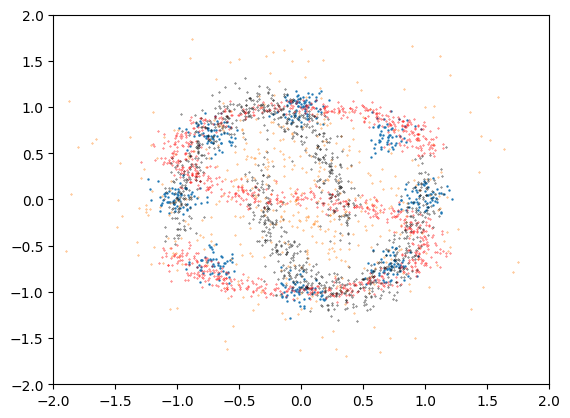

In [28]:
X = dist.sample(512)

plt.scatter(*X.T, s=0.5)
plt.scatter(*torch.randn(2, 512) * 0.7, s=0.1, alpha=0.9)
plt.scatter(*s_curve.sample(1024).T, s=0.1, alpha=0.9, c='r')
plt.scatter(*moons.sample(1024).T, s=0.1, alpha=0.9, c='black')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()